# Problem Set 3

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown. You will submit only this notebook named: [jhed_id].ipynb back to Blackboard from whence you downloaded it. Do not return the data to me.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**

## Abalone

This is a problem about Abalone...but not really. You should be able to use common knowledge to work with the data in this problem.

```
Description of fields in abalone data.

Name            Data Type    Meas.    Description
----            ---------    -----    -----------
Sex             nominal               M, F, and I (infant)
Length          continuous    mm      Longest shell measurement
Diameter        continuous    mm      perpendicular to length
Height          continuous    mm      with meat in shell
Whole weight    continuous    grams   whole abalone
Shucked weight  continuous    grams   weight of meat
Viscera weight  continuous    grams   gut weight (after bleeding)
Shell weight    continuous    grams   after being dried
Rings           integer               +1.5 gives the age in years
```

The target variable is Rings because it is a predictor of age. You can take this as your problem, "How do we estimate the age of an abalone from the available data?"

At a high level you have:

1. Question/Problem
2. ETL
3. EDA
4. Statistical and Mathematical Modeling.

Of necessity, there is very little ETL here except to verify that the data has loaded correctly and with the correct types. For the EDA and Modeling parts, follow the guidelines in *Fundamentals*.


**Begin**

In [1]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

sns.set(style="whitegrid")

## Question/Problem

"How do we estimate the age of an abalone from the available data?"

## ETL

I'll just be loading in the csv file and viewing that the data was loaded in correctly.

In [2]:
data = pd.read_csv("abalone.original.csv")

In [3]:
data.head()

,M,91,73,19,102.8,44.9,20.2,30,15
0,M,70,53,18,45.1,19.9,9.7,14.0,7
1,F,106,84,27,135.4,51.3,28.3,42.0,9
2,M,88,73,25,103.2,43.1,22.8,31.0,10
3,I,66,51,16,41.0,17.9,7.9,11.0,7
4,I,85,60,19,70.3,28.2,15.5,24.0,8


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 9 columns):
M        4176 non-null object
91       4176 non-null int64
73       4176 non-null int64
19       4176 non-null int64
102.8    4176 non-null float64
44.9     4176 non-null float64
20.2     4176 non-null float64
30       4176 non-null float64
15       4176 non-null int64
dtypes: float64(4), int64(4), object(1)
memory usage: 293.7+ KB


Looks like the original file does not have headers. I'll have to add them manually. I found this suggestion to input names directly inthe pd.read_csv call: https://stackoverflow.com/questions/34091877/how-to-add-header-row-to-a-pandas-dataframe

In [5]:
data = pd.read_csv("abalone.original.csv", names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"])

In [6]:
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,91,73,19,102.8,44.9,20.2,30.0,15
1,M,70,53,18,45.1,19.9,9.7,14.0,7
2,F,106,84,27,135.4,51.3,28.3,42.0,9
3,M,88,73,25,103.2,43.1,22.8,31.0,10
4,I,66,51,16,41.0,17.9,7.9,11.0,7


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null int64
Diameter          4177 non-null int64
Height            4177 non-null int64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(4), int64(4), object(1)
memory usage: 293.8+ KB


That is much better. The info lines up too, so we are good to move on.

## EDA

In [8]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Single Variable

### Sex

Sex is a categorical variable with three options here; male, female, and infant. The infant variable is interesting as it isn't a sex but would be an appropriate categorical variable to determine the number of rings. I would expect an even split between the three but with potentially more M/F than I. 

In how sex affects rings, it is possible that M or F may predict age if one lives longer than the other but the I category will definitely be lower as it is intentionally younger.

In [9]:
pd.DataFrame(data["Sex"].value_counts().sort_index())

,Sex
F,1307
I,1342
M,1528


There are a good amount more males than the other two but I am a bit surprised by the amount of infants which is greater than the females. A frequency plot will show more detail in how different they are.

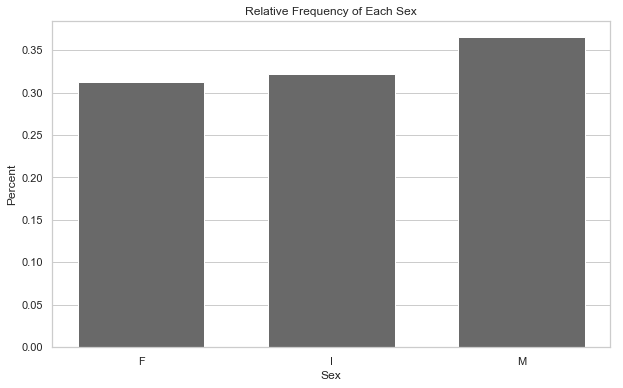

In [10]:
counts = data["Sex"].value_counts().sort_index()
proportions = data["Sex"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Sex")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of Each Sex")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

This shows how close the F and I catergories are but how much larger the M category is. Males have a good chunk more than the other two.

### Length

I would expect length to have some impact on rings. As the abalone ages they grow in some capacity. Length is in mm so there will be some spread from the infants to the adults and everything in between.

Length is a numerical multiplicative variable that should start relatively low for the infants.

In [11]:
data["Length"].describe()

count   4177.00
mean     104.80
std       24.02
min       15.00
25%       90.00
50%      109.00
75%      123.00
max      163.00
Name: Length, dtype: float64

As expected there is a reasonably large spread from 15 mm to 163 mm. The data is skewed as the median is a bit larger than the mean. Also the 75th percentile is 14 mm larger than 50 while 25 is 19 mm smaller. We'll be able to see the distribution better with a horizontal box plot.

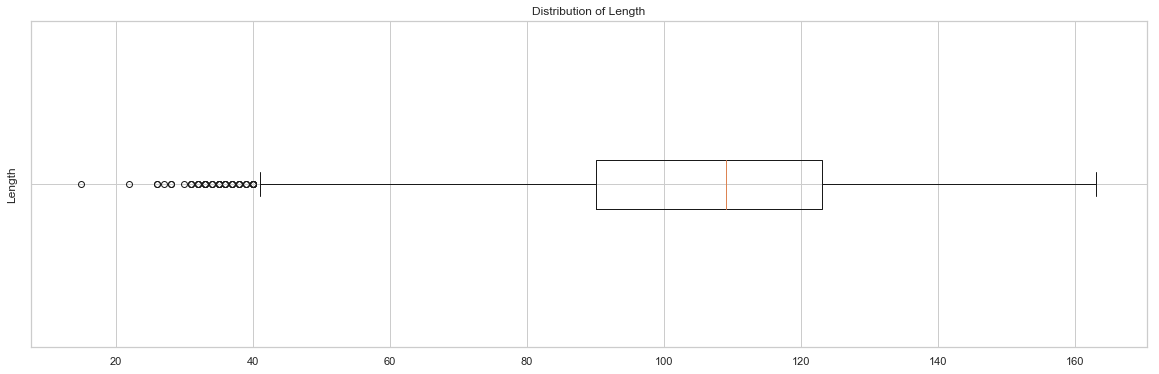

In [12]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "Length"], labels=[''], showfliers=True, patch_artist=False, zorder=1, vert=False)
axes.set_title("Distribution of Length")
axes.set_ylabel("Length")

plt.show()
plt.close()

There are a significant amount of outliers on the lower end from 40 mm and below which would make sense if they are infants. As there are more adults than infants (almost 3000 to 1300) most of the data will be in the adult range of lengths.

### Diameter

Diameter should also have a similar impact on rings. As the abalone ages they grow in some capacity. Diameter is also in mm so there will be some spread from the infants to the adults just like length.

Diameter is a numerical multiplicative variable that should start relatively low for the infants.

In [13]:
data["Diameter"].describe()

count   4177.00
mean      81.58
std       19.85
min       11.00
25%       70.00
50%       85.00
75%       96.00
max      130.00
Name: Diameter, dtype: float64

This has a very similar distribution to the length variable. I will take a look at the box plot and then also take a look at a histogram to get a different picture of the data.

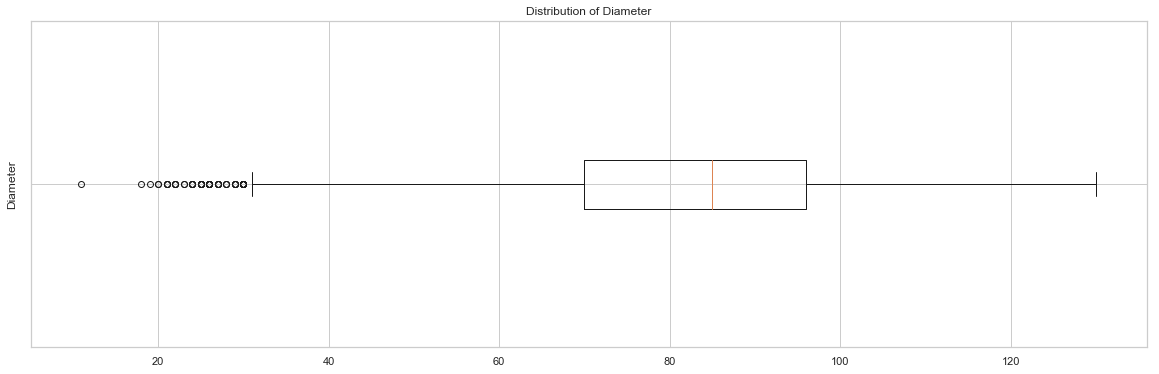

In [14]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "Diameter"], labels=[''], showfliers=True, patch_artist=False, zorder=1, vert=False)
axes.set_title("Distribution of Diameter")
axes.set_ylabel("Diameter")

plt.show()
plt.close()

That looks extremely similar to the box plot from the length.

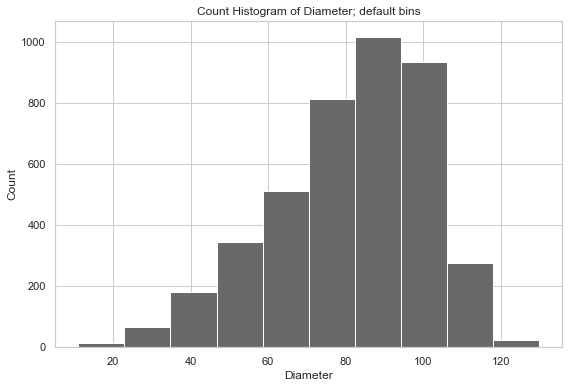

In [15]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Diameter"], color="DimGray")
axes.set_ylabel( "Count")
axes.set_xlabel( "Diameter")
axes.set_title("Count Histogram of Diameter; default bins")

plt.show()
plt.close()

The histogram gives a better picture than the box plot for the distribution. The box plot does help show how the smaller data are outliers but the histogram shows the gradual increase to aroudnd 80 - 100 and the immediate drop off after.

### Height

Height, like length and diameter, will increase with age. It should have a similar distribution to the other two.

It is also a mutiplicative numerical variable.

In [16]:
data["Height"].describe()

count   4177.00
mean      27.90
std        8.37
min        0.00
25%       23.00
50%       28.00
75%       33.00
max      226.00
Name: Height, dtype: float64

There is a data point that has a height of 0 which doesn't make much sense, as well as a height of 226. I will check on those data points.

In [17]:
data[(data["Height"] == 0)]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,86,68,0,85.60,41.30,17.20,23.00,8
3996,I,63,46,0,26.80,11.50,5.70,70.10,6


They are both infants yet still have other size so this must be some form of error.

In [18]:
data[(data["Height"] == 226)]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
2051,F,91,71,226,118.80,66.40,23.20,26.70,8


The weight is large but the height is still absurdly large. I would guess it was supposed to be 26 and they fat fingered the data but that is a guess.

I will plot the data with box plot and histogram to compare the length and diameter.

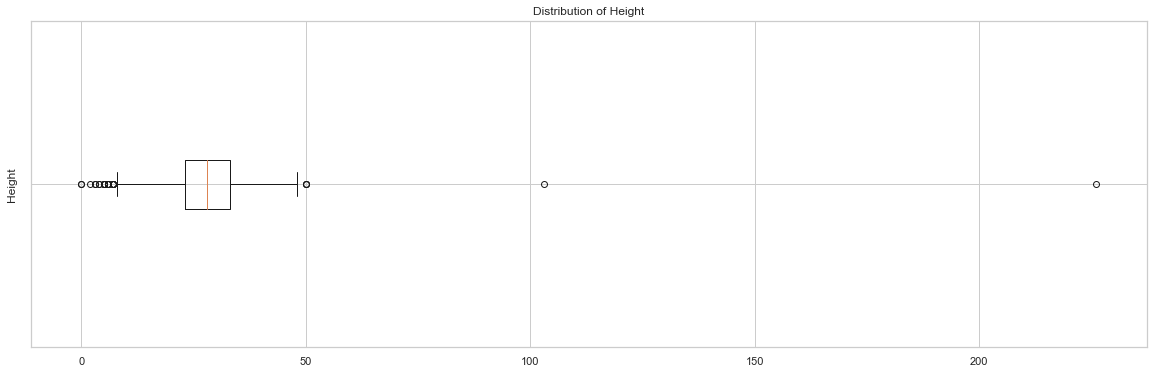

In [19]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "Height"], labels=[''], showfliers=True, patch_artist=False, zorder=1, vert=False)
axes.set_title("Distribution of Height")
axes.set_ylabel("Height")

plt.show()
plt.close()

We can more clearly see the outlier of 226 but we also see one right above 100 which I could guess is also a mistake. There are some smaller ones close to 0 which makes sense for the infants. Overall, the data otherwise is distributed nicely around the 50th percentile which we could see better with a histogram.

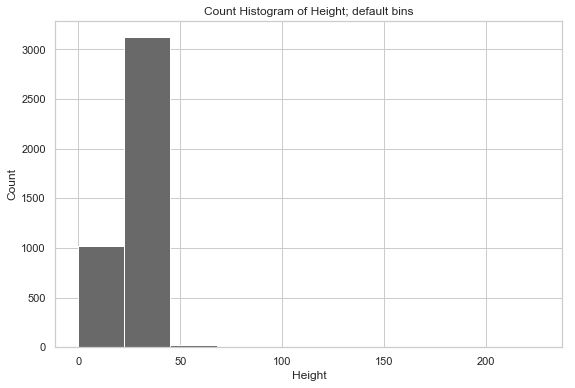

In [20]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Height"], color="DimGray")
axes.set_ylabel( "Count")
axes.set_xlabel( "Height")
axes.set_title("Count Histogram of Height; default bins")

plt.show()
plt.close()

The default bin size does not work with those silly outliers so I will change up the bin size.

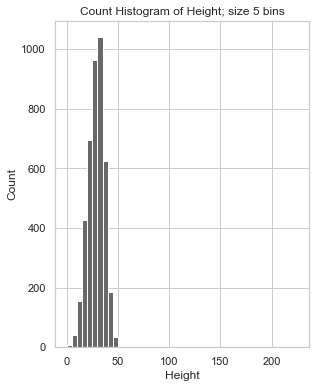

In [21]:
bins = [0 + i for i in range( 0, 226, 5)]

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Height"], bins=bins, density=False, color="DimGray")

axes.set_title("Count Histogram of Height; size 5 bins")
axes.set_ylabel( "Count")
axes.set_xlabel( "Height")
plt.show()
plt.close()

Going from 0 to 226 for bins doesn't make much sense but the above bin size fits reasonably and shows a normal distribution to some extent for height.

### Whole weight

Whole weight is a multiplicative numerical variable. As the abalone ages the weigth should increase, however it is also possible that once it reaches a certain age, it will weigh less and less.

For strictly just the weight distribution of the data, I would expect something similar to the last three.

In [22]:
data["Whole weight"].describe()

count   4177.00
mean     165.75
std       98.08
min        0.40
25%       88.30
50%      159.90
75%      230.60
max      565.10
Name: Whole weight, dtype: float64

The minimum weight here also seems to be a mistake. The rest of the data looks distributed around the mean and median which are pretty close together given the seeming outliers. For weights I will compare them with a vertical box plot initially. A histogram will help as well. 

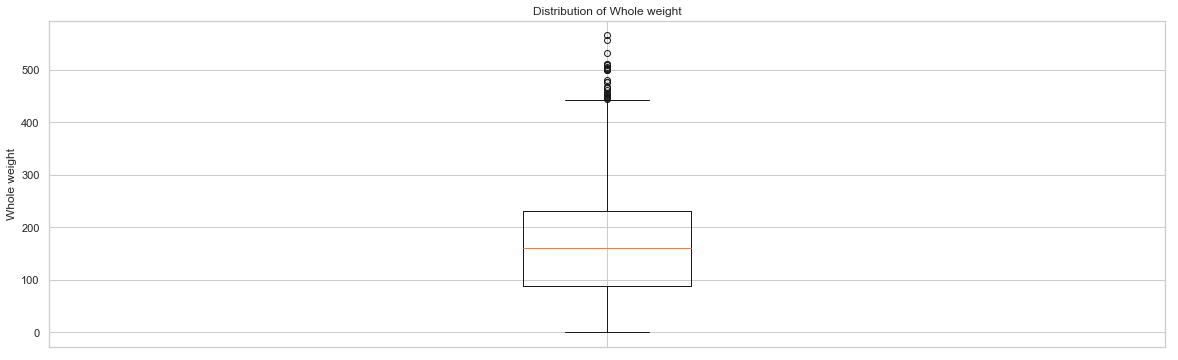

In [23]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "Whole weight"], labels=[''], showfliers=True, patch_artist=False, zorder=1)
axes.set_title("Distribution of Whole weight")
axes.set_ylabel("Whole weight")

plt.show()
plt.close()

I could see there being many more heavier outliers as it's possible that weight can flucuate more than the length measurements (at least with people or other animals). This does make sense as the mean was slightly larger than the median.

### Shucked weight

Another weight variable, shucked weight is also a multiplicative numerical variable. This is strictly the weight of the meat inside the shell. This will have large spread as infants may have small amounts of meat and the larger ones will gain lots of meat as they age.

In [24]:
data["Shucked weight"].describe()

count   4177.00
mean      71.87
std       44.39
min        0.20
25%       37.20
50%       67.20
75%      100.40
max      297.60
Name: Shucked weight, dtype: float64

Again, there is a much smaller one weighing almost 0. It also has a mean that is slightly larger than the median. The max is almost three times larger than the 75th percentile. I could imagine similar outliers to the Whole weight. Let's compare with the box plot.

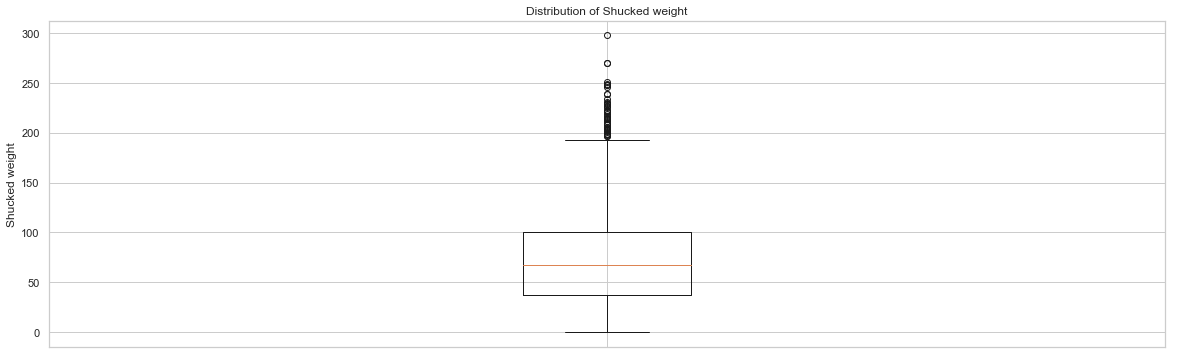

In [25]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "Shucked weight"], labels=[''], showfliers=True, patch_artist=False, zorder=1)
axes.set_title("Distribution of Shucked weight")
axes.set_ylabel("Shucked weight")

plt.show()
plt.close()

The distribution is almost identical so I would imagine the shell weight to look the same as well since Shell plus Shucked should equal Whole.

### Viscera weight

Viscera weight is a mulplicative numerical variable as well. It's the same as what I said above for shucked weight as it's the same meat but after bleeding.

In [26]:
data["Viscera weight"].describe()

count   4177.00
mean      36.12
std       21.92
min        0.10
25%       18.70
50%       34.20
75%       50.60
max      152.00
Name: Viscera weight, dtype: float64

The numbers are like the above but smaller as expected. We won't know the full extent of the change in the distribution until we plot the box plot.

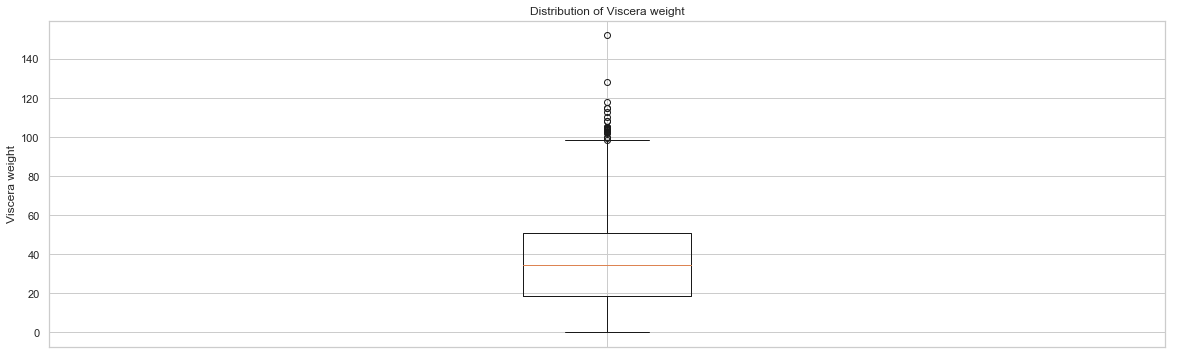

In [27]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "Viscera weight"], labels=[''], showfliers=True, patch_artist=False, zorder=1)
axes.set_title("Distribution of Viscera weight")
axes.set_ylabel("Viscera weight")

plt.show()
plt.close()

It does look the same again. I am interested though in how this looks in histogram form and how it changed from the Shucked weight.

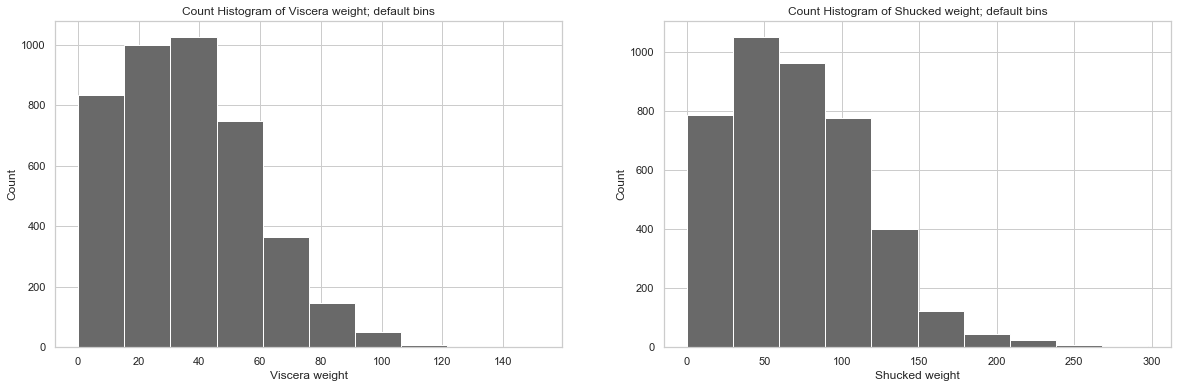

In [28]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Viscera weight"], color="DimGray")
axes.set_ylabel( "Count")
axes.set_xlabel( "Viscera weight")
axes.set_title("Count Histogram of Viscera weight; default bins")

axes = figure.add_subplot(1, 2, 2)
axes.hist( data[ "Shucked weight"], color="DimGray")
axes.set_ylabel( "Count")
axes.set_xlabel( "Shucked weight")
axes.set_title("Count Histogram of Shucked weight; default bins")

plt.show()
plt.close()

With the same bin size they pretty much look the same however there is some change in the lower end. It's harder to evaluate those differences as it's all skewed right so much.

### Shell weight

Last weight. It should be the same as the others.

In [29]:
data["Shell weight"].describe()

count   4177.00
mean      47.77
std       27.84
min        0.30
25%       26.00
50%       46.80
75%       65.80
max      201.00
Name: Shell weight, dtype: float64

The minimum is still there while the mean is slightly larger than the median and the max is much larger than the 75th percentile (over 3 times larger this time). We can see this distribution better in a box plot.

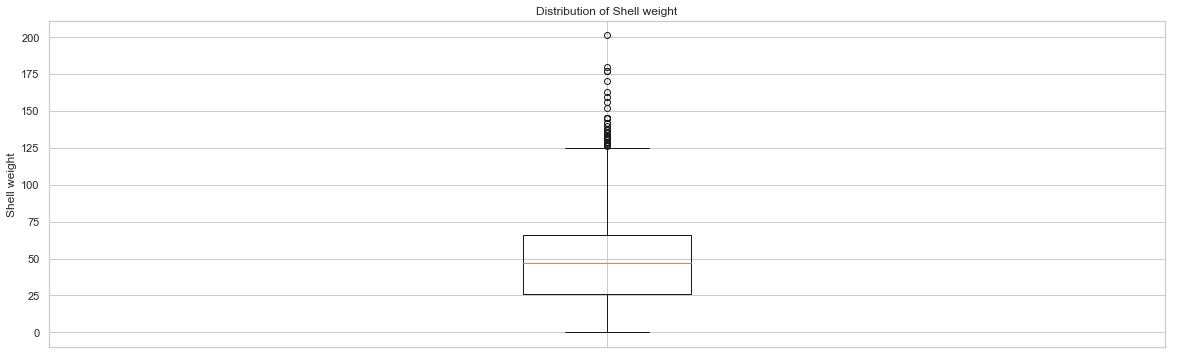

In [30]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "Shell weight"], labels=[''], showfliers=True, patch_artist=False, zorder=1)
axes.set_title("Distribution of Shell weight")
axes.set_ylabel("Shell weight")

plt.show()
plt.close()

Again the distribution looks just like the other weights.

### Rings

Rings is the target variable as it is used to predict age. Rings is multiplicative real values. It may start at 0 or close to it depending on when the first ring forms for infants.

In [31]:
data["Rings"].describe()

count   4177.00
mean       9.93
std        3.22
min        1.00
25%        8.00
50%        9.00
75%       11.00
max       29.00
Name: Rings, dtype: float64

There are no data points with 0 rings as the minimum is 1. The 25th percentile is almost equal to the median of 9 as well as the 75th percentile of 11. This is striking as the max is 29. As rings are discrete values I would like to get a value count for each amount.

In [32]:
pd.DataFrame(data["Rings"].value_counts().sort_index())

,Rings
1,1
2,1
3,15
4,57
5,115
6,259
7,391
8,568
9,689
10,634


We see few from 1 to 3 and then it starts taking off where most of them are between 8 and 11. Then it tails off until 29. This would look good with a histogram.

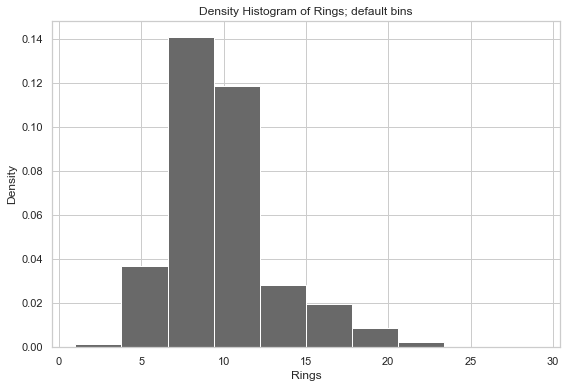

In [33]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Rings"], density=True, color="DimGray")
axes.set_ylabel( "Density")
axes.set_xlabel( "Rings")
axes.set_title("Density Histogram of Rings; default bins")

plt.show()
plt.close()

We see the significant concentration around 10 here. We can get a bit more discrete with smaller bin sizes.

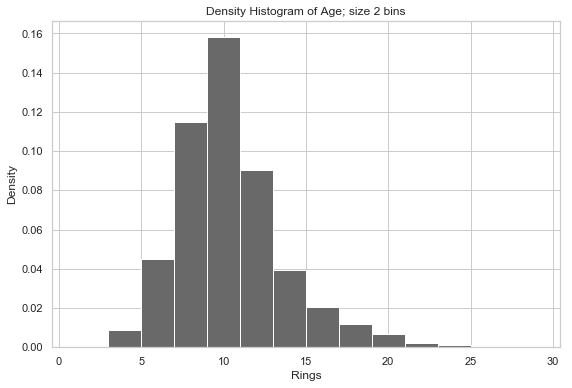

In [34]:
figure = plt.figure(figsize=(20, 6))
bins = [1 + i for i in range( 0, 29, 2)]

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Rings"], bins=bins, density=True, color="DimGray")
axes.set_ylabel( "Density")
axes.set_xlabel( "Rings")
axes.set_title("Density Histogram of Age; size 2 bins")

plt.show()
plt.close()

With size 2 bins we see the distribution a bit better as it increases til 10 and begins to decrease.

### Pairwise Exploration

With pairwise exploration I will only go through a few of these as there are many different combinations. Specifically the weight and the size variables all showed extrememly similar distributions, and it is relatively straightforward to tell from those that they each have a similar relationship. 

Since length and whole weight seemed to have good data and are simple to interpret I will focus my exploration with those two variables.

In [35]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    print( "r   =", stats.pearsonr(data[x], data[y])[0])
    print( "rho =", stats.spearmanr(data[x], data[y])[0])

In [36]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

### Sex and Length

There are a few categories here with sex that may have a relationship with length. Infants (I) should sway the length category to the lower end since they have not grown as much. However, male (M) and female (F) may also have an effect on length. One may be consistently larger than the other.

In [37]:
grouped = data.groupby( "Sex")
grouped_length = grouped["Length"].describe()
print(grouped_length)

      count   mean   std   min    25%    50%    75%    max
Sex                                                       
F   1307.00 115.82 17.23 55.00 105.00 118.00 128.00 163.00
I   1342.00  85.55 21.77 15.00  72.00  87.00 102.00 145.00
M   1528.00 112.28 20.54 31.00 101.00 116.00 126.00 156.00


As expected, we see a much smaller minimum for infant with a smaller mean. The max for infant does get large though. Additionally, female iis slightly larger than male at each percentile with a smaller standard deviation. We can view this difference with a horizontal box plot.

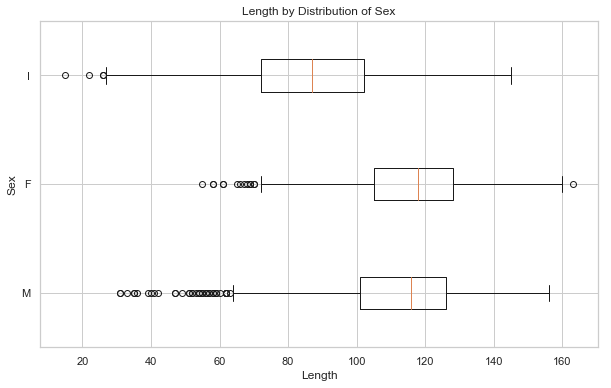

In [38]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

labels = pd.unique(data["Sex"].values)
grouped_data = [grouped[ "Length"].get_group( k) for k in labels]
patch = axes.boxplot( grouped_data, labels=labels, patch_artist=False, zorder=1, vert=False)

axes.set_xlabel("Length")
axes.set_ylabel("Sex")
axes.set_title("Length by Distribution of Sex")

plt.show()
plt.close()

Again, we see the distribution for infants with a smaller mean and smaller everything in general. Additionally, we see that males have a large amount of small outliers with many in the 30s and 40s while none of the females go that low.

### Sex and Whole weight

The comparison with sex and whole weight will be similar to that of the length comparison above. I do believe it will be much different.

In [39]:
grouped = data.groupby( "Sex")
grouped_weight = grouped["Whole weight"].describe()
print(grouped_weight)

      count   mean   std   min    25%    50%    75%    max
Sex                                                       
F   1307.00 209.31 86.06 16.00 146.00 207.70 264.05 531.40
I   1342.00  86.27 57.25  0.40  41.10  76.80 119.88 409.90
M   1528.00 198.29 94.12  3.10 134.32 195.15 253.12 565.10


The infant category has a much smaller mean and distribution in general. Again the male distribution is on the lower end compared to the female. However, the max for males is larger than females which was not the case for length. Let's plot this out with a similar box plot for comparison.

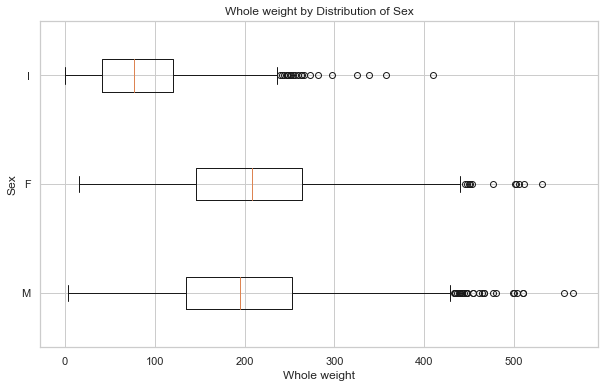

In [40]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

labels = pd.unique(data["Sex"].values)
grouped_data = [grouped[ "Whole weight"].get_group( k) for k in labels]
patch = axes.boxplot( grouped_data, labels=labels, patch_artist=False, zorder=1, vert=False)

axes.set_xlabel("Whole weight")
axes.set_ylabel("Sex")
axes.set_title("Whole weight by Distribution of Sex")

plt.show()
plt.close()

In general the distributions are similar to length with infants being much smaller and females being slightly larger than males. However, with males they have a large amount of bigger outliers. They may not grow as long but larger ones may weigh more.

### Sex and Rings

The significant comparisons here are with rings as that is the target variable. As rings has a relationship with age, I will expect the infant to have fewer rings than males and females. Males and females may differ based on how old males or females can become or even how many rings appear as each ages.

In [41]:
grouped = data.groupby( "Sex")
grouped_rings = grouped["Rings"].describe()
print(grouped_rings)

      count  mean  std  min  25%   50%   75%   max
Sex                                               
F   1307.00 11.13 3.10 5.00 9.00 10.00 12.00 29.00
I   1342.00  7.89 2.51 1.00 6.00  8.00  9.00 21.00
M   1528.00 10.71 3.03 3.00 9.00 10.00 12.00 27.00


As expected, infants have less rings across the board but surprisingly there is one with a max of 21. I am curious where the age cutoff between infant and adult lies in this data set. Additionally, males and females have comparable distributions but the female min and max are both larger driving up the mean a .42 rings above males. We can compare these with a vertical box plot.

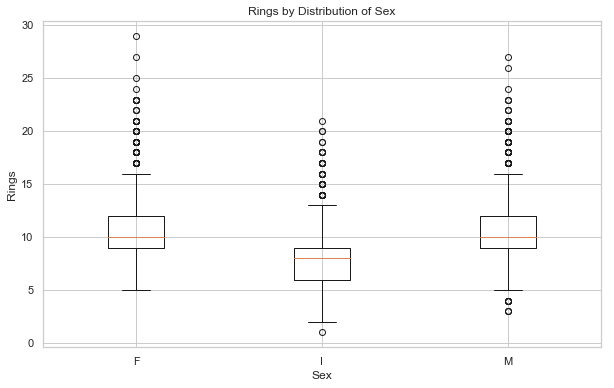

In [42]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

labels = pd.unique(data["Sex"].values)
labels.sort()
grouped_data = [grouped[ "Rings"].get_group( k) for k in labels]
patch = axes.boxplot( grouped_data, labels=labels, patch_artist=False, zorder=1, vert=True)

axes.set_xlabel("Sex")
axes.set_ylabel("Rings")
axes.set_title("Rings by Distribution of Sex")

plt.show()
plt.close()

The main comparison I want to make here is between male and female as infants are lower as expected. The quantile disbribution is identical for F and M but males have a few outliers on the lower end while females have a few more outliers on the upper end. I would like to histograms of each to see the amounts split up.

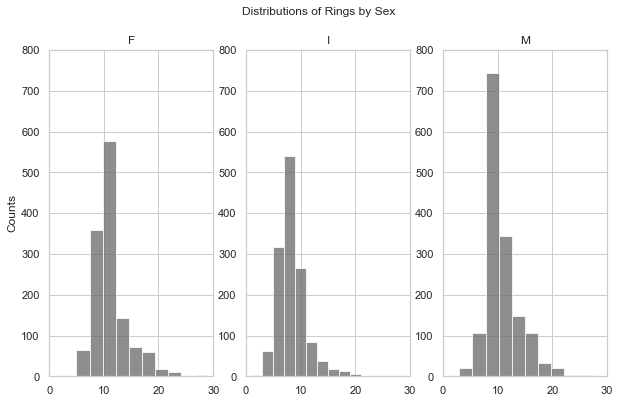

In [43]:
figure = plt.figure(figsize=(10, 6))
figure.suptitle("Distributions of Rings by Sex")

for i in enumerate( labels):
    axes = figure.add_subplot(1, 3, i[0] + 1)
    subdata = grouped["Rings"].get_group(i[1]).values
    axes.hist(subdata, alpha=0.75, color="DimGray")
    axes.set_title(labels[i[0]])
    axes.set_ylim((0,800))
    axes.set_xlim((0,30))
    if (i[0] > 2):
        axes.set_xlabel("Sex")
    if (i[0] % 3 == 0):
        axes.set_ylabel("Counts")

plt.show()
plt.close()

We see for the adults that most are focused around 10 rings with males slightly lower than 10 and females slightly higher than 10. The infants are focused closer to 7 and 8.

### Length and Whole weight

Length and whole weigth are both variables that are indicative of the size fo the abalone so I expect there to be a very strong correlation between the two.

In [44]:
correlation(data, "Length", "Whole weight")

Correlation coefficients:
('r   =', 0.9252611721489453)
('rho =', 0.972632891186567)


As expected, the correlation is high with an r of 0.925. I would expect the relationship between all of the different size variables to have the same relationship and correlation.

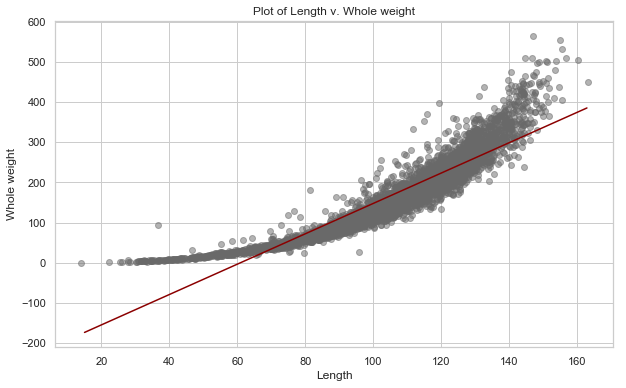

In [45]:
lowess_scatter(data, "Length", "Whole weight", jitter=0.01, skip_lowess=True)

With a linear regression model, the correlation between the two was very good. The plotted data above shows a clear exponential relationship, so I would expect an even better model if adjusted correctly.

### Length and Rings

Length and rings should have some correlation in the lower end of their data sets and then once rings gets to a certain point the correlation will change. My assumption is that since it seems there is a cutoff of sorts for infants at about 8 rings, this is where the relationship will start varying more.

In [46]:
correlation(data, "Length", "Rings")

Correlation coefficients:
('r   =', 0.5567195769296179)
('rho =', 0.6043853354046326)


There is some solid correlation here but it is not as good as the prior one. Again I believe this is due to adults no longer continuing to grow once they reach adulthood. The length could vary greatly and even randomly based on the number of rings after they become adults.

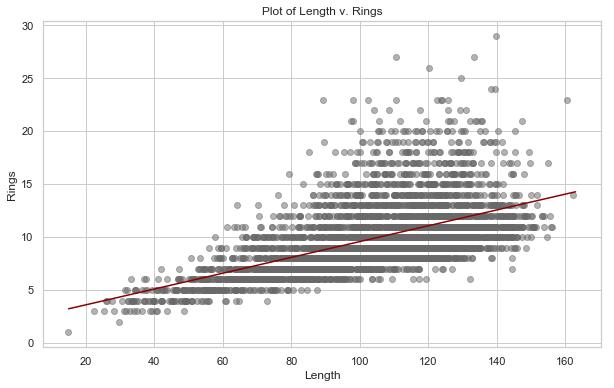

In [47]:
lowess_scatter(data, "Length", "Rings", jitter=0.01, skip_lowess=True)

The relationship expands out as length and rings gets larger as I had hypothesized.

### Whole weight and Rings

I expect a nearly identical relationship with whole weight and rings as with length and rings. There may be more correlation as weight could fluctuate a bit more with age than length can.

In [48]:
correlation(data, "Whole weight", "Rings")

Correlation coefficients:
('r   =', 0.5403896769239007)
('rho =', 0.6308319554663986)


The rho coefficient is a small bit larger than the length and rings correlation but r is actually .01 smaller. So they are basically the same. We can see the full relationship with a scatterplot.

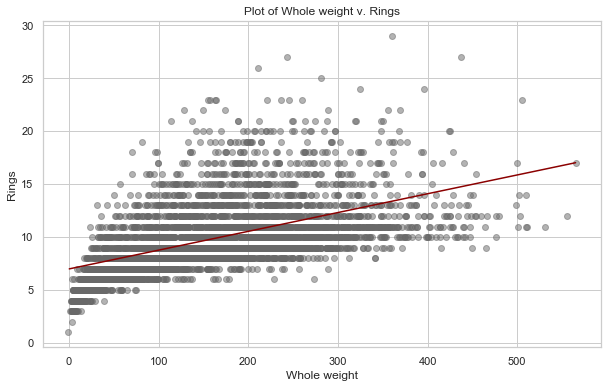

In [49]:
lowess_scatter(data, "Whole weight", "Rings", jitter=0.01, skip_lowess=True)

There is a similar visual of a larger spread the larger both values get. However, it looks like it takes a few years for any growth for the whole weight.

## Statistical and Mathematical Modeling

### Sex

Sex is an interesting model as there are three different categories, male, female, and infant. We could go beyond just those three as well and split them to adult and infant as well. 

With the initial three, we can look at the probability of an abalone being in each category. This would be a Bernoulli distribution for each category; the probability of a success for male, the probability of success for female, and the probability of success for infant.

We essentially got this data in our EDA. I will redisplay it here under this context. We only displayed the value counts initially. For a Bernoulli distribution we need to calculate the probability of each category.

In [50]:
pd.DataFrame(data["Sex"].value_counts().sort_index()/data["Sex"].count())

,Sex
F,0.31
I,0.32
M,0.37


This is our probability for a success for each category, which can be plotted with a bar chart.

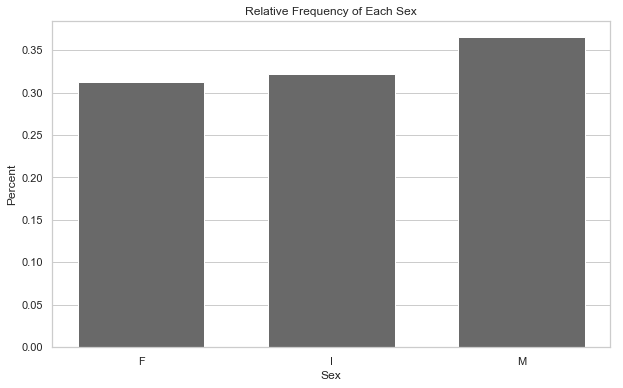

In [51]:
counts = data["Sex"].value_counts().sort_index()
proportions = data["Sex"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Sex")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of Each Sex")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

### Length

For the follow distributions, I plotted a lot of them with only box plots. Finding the right distribution for the data can be easier with histograms. For length I did not create a histogram so I am plotting it below.

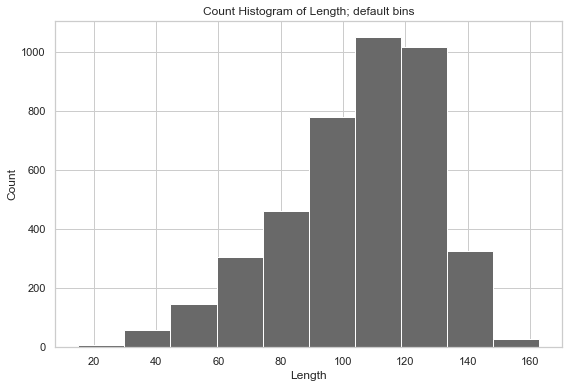

In [52]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Length"], color="DimGray")
axes.set_ylabel( "Count")
axes.set_xlabel( "Length")
axes.set_title("Count Histogram of Length; default bins")

plt.show()
plt.close()

The above distribution is somewhat normal but since the data is skewed left a normal distribution will not cover the edges of the data as accurately. Below is the same histogram but with the normal distribution with it.

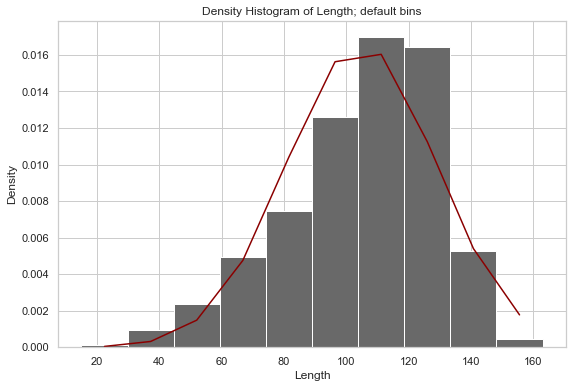

In [53]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
n, bins, patches = axes.hist( data[ "Length"], color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Length")
axes.set_title("Density Histogram of Length; default bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Length"])
std = np.std(data["Length"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


Because of the left skew, the normal distribution does not properly model the distribution. It over estimates the amount with a length of 100 or less and over estimates with 100 or more.

### Diameter

Diameter should also have a somewhat normal distribution because any growth matches the normal's generating story of small additive effects. I will start by generating the histogram with the normal distribution.

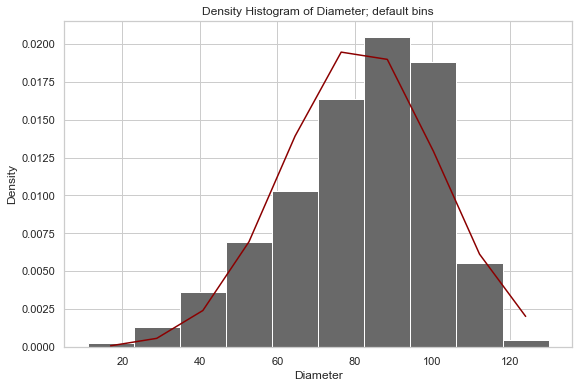

In [54]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
n, bins, patches = axes.hist( data[ "Diameter"], color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Diameter")
axes.set_title("Density Histogram of Diameter; default bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Diameter"])
std = np.std(data["Diameter"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


This distribution is the same as length as it overestimates the lower end and under estimates the higher end as it is skewed left.

### Height

As we saw when generating the original histogram for height, there was a large outlier in the data set, but the rest of the data looked relatively normal. I will plot the histogram again, but this time with the normal distribution.

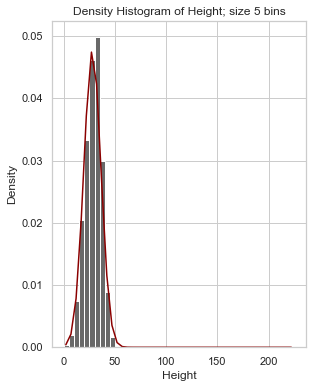

In [55]:
bins = [0 + i for i in range( 0, 226, 5)]

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Height"], bins=bins, density=True, color="DimGray")

axes.set_title("Density Histogram of Height; size 5 bins")
axes.set_ylabel( "Density")
axes.set_xlabel( "Height")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Height"])
std = np.std(data["Height"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

The distribution fits remarkably well. There is a slight underestimation of just above the mean but for the most part, the bins of the histogram fit perfectly into the distribution function.

### Whole weight

Weight's all fit the normal distribution generation story for the same reason that the above measurements do. The weights were all skewed to the right though, so we may see different results.

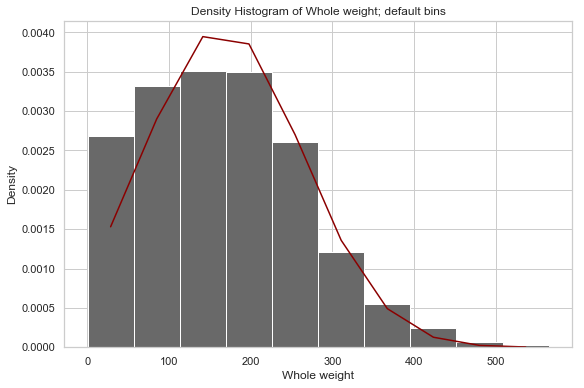

In [56]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
n, bins, patches = axes.hist( data[ "Whole weight"], color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Whole weight")
axes.set_title("Density Histogram of Whole weight; default bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Whole weight"])
std = np.std(data["Whole weight"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


Here, bin size might be an issue as we do not differentiate between the lower totals as much. I will lower the bin size to see if that helps with our distribution.

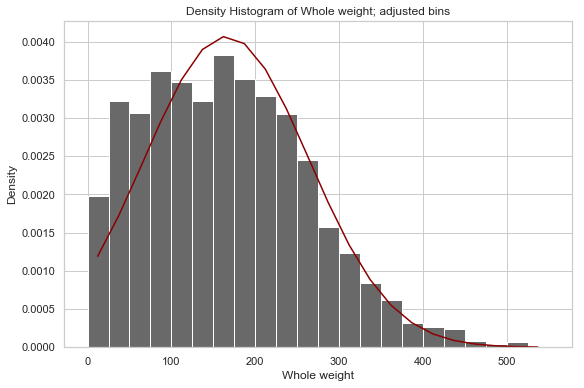

In [57]:
bins = [0 + i for i in range( 0, 570, 25)]

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Whole weight"], bins=bins, color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Whole weight")
axes.set_title("Density Histogram of Whole weight; adjusted bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Whole weight"])
std = np.std(data["Whole weight"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


The smaller bin size gives a better picture for the distribution of the data. The normal distbribution kind of works however the tough aspect is weight cannot go below 0, so all of the data from 0 to 100 is more concentrated and the distribution is underestimating. Around the mean, the distribution is overestimating as well.

### Shucked weight

I expect to see similar distributions for the remainder of the weight measurements. I will plot with default bin sizes and adjust as needed.

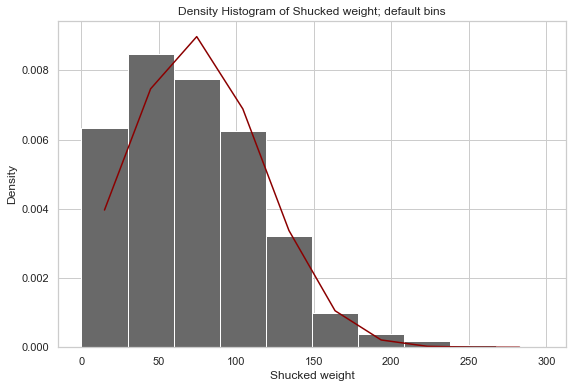

In [58]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
n, bins, patches = axes.hist( data[ "Shucked weight"], color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Shucked weight")
axes.set_title("Density Histogram of Shucked weight; default bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Shucked weight"])
std = np.std(data["Shucked weight"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


Again, similar to whole weight, so I will adjust the bins.

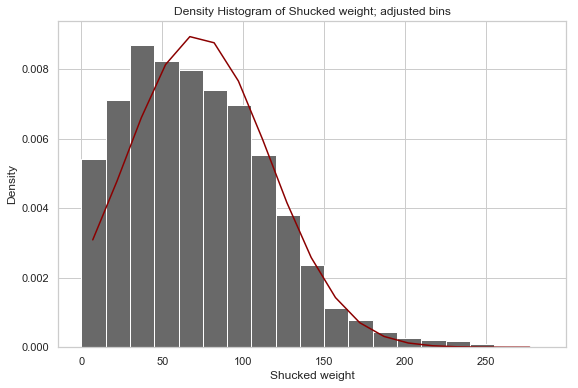

In [59]:
bins = [0 + i for i in range( 0, 300, 15)]

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Shucked weight"], bins=bins, color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Shucked weight")
axes.set_title("Density Histogram of Shucked weight; adjusted bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Shucked weight"])
std = np.std(data["Shucked weight"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


With smaller bins, we see how the rigth skew is pulling the distribution model and mean much greater than the median of the data. The model is over estimating the smaller weights and over estimating around the mean.

### Viscera weight

I will perform what I did above for viscera weigth.

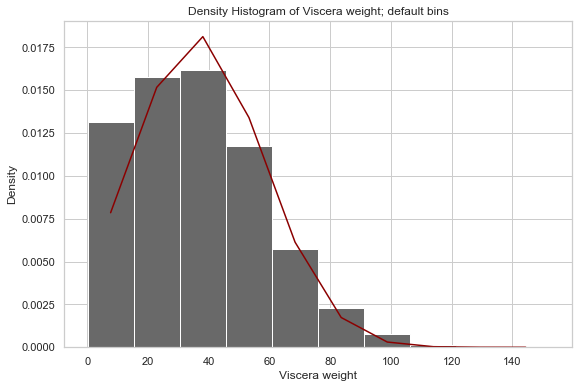

In [60]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
n, bins, patches = axes.hist( data[ "Viscera weight"], color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Viscera weight")
axes.set_title("Density Histogram of Viscera weight; default bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Viscera weight"])
std = np.std(data["Viscera weight"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


Smaller bins will help with the lower weight values.

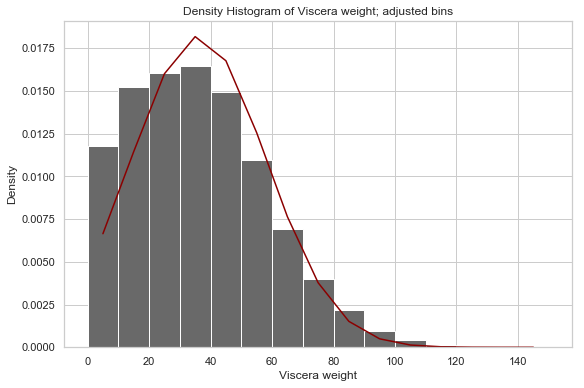

In [61]:
bins = [0 + i for i in range( 0, 155, 10)]

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Viscera weight"], bins=bins, color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Viscera weight")
axes.set_title("Density Histogram of Viscera weight; adjusted bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Viscera weight"])
std = np.std(data["Viscera weight"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


Once again the normal distribution will under estimate for the smaller values and over estimate around the mean.

### Shell weight

Last weight. I'll perform the same plots as the others.

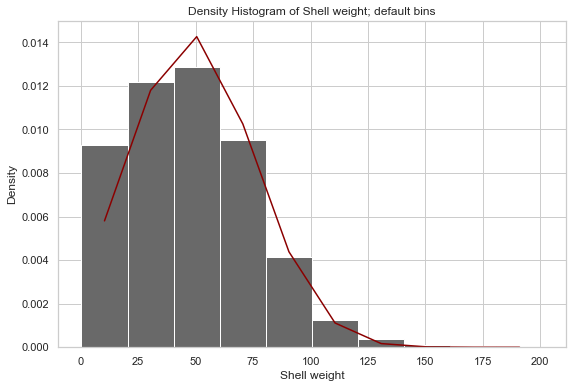

In [62]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
n, bins, patches = axes.hist( data[ "Shell weight"], color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Shell weight")
axes.set_title("Density Histogram of Shell weight; default bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Shell weight"])
std = np.std(data["Shell weight"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


At first glance, shell weight may already be the best fitting normal. However, I will take a look at smaller bins as well.

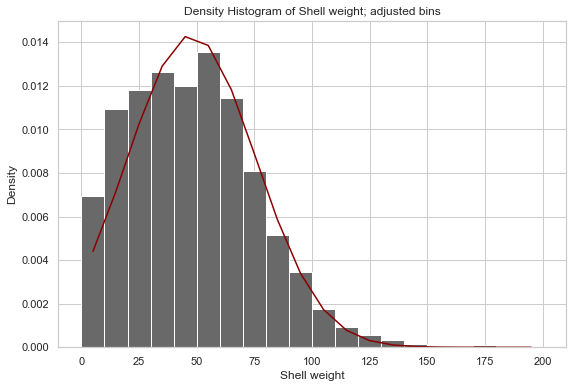

In [63]:
bins = [0 + i for i in range( 0, 205, 10)]

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Shell weight"], bins=bins, color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Shell weight")
axes.set_title("Density Histogram of Shell weight; adjusted bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Shell weight"])
std = np.std(data["Shell weight"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


The normal fits slightly better here however, there is still an underestimation for smaller data and an overestimation around the mean.

### Rings

Rings should also have some kind of normal distribution going. I'll replot the density histogram from previously to show.

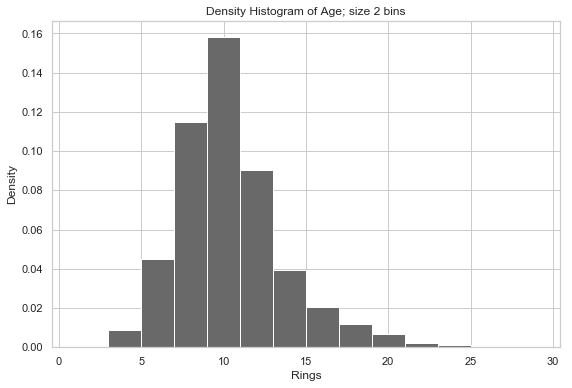

In [64]:
figure = plt.figure(figsize=(20, 6))
bins = [1 + i for i in range( 0, 29, 2)]

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Rings"], bins=bins, density=True, color="DimGray")
axes.set_ylabel( "Density")
axes.set_xlabel( "Rings")
axes.set_title("Density Histogram of Age; size 2 bins")

plt.show()
plt.close()

This probably looks the most normal of all of them even with the slight skew. Below is a plot with the added distribution line.

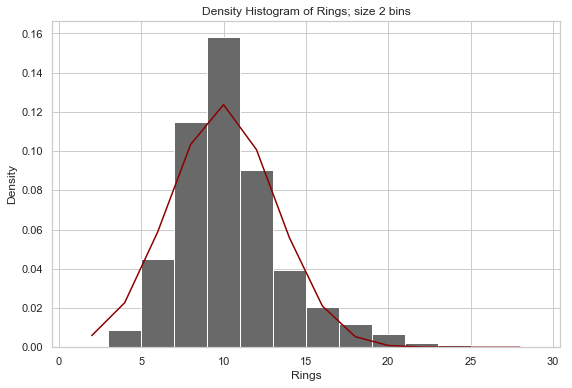

In [65]:
bins = [1 + i for i in range( 0, 29, 2)]

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Rings"], bins=bins, color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Rings")
axes.set_title("Density Histogram of Rings; size 2 bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Rings"])
std = np.std(data["Rings"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


Interestingly, the distribution way under estimates the mean as almost 16% of the data lies in that fourth bin. I am curious what this would look like with size 1 bins.

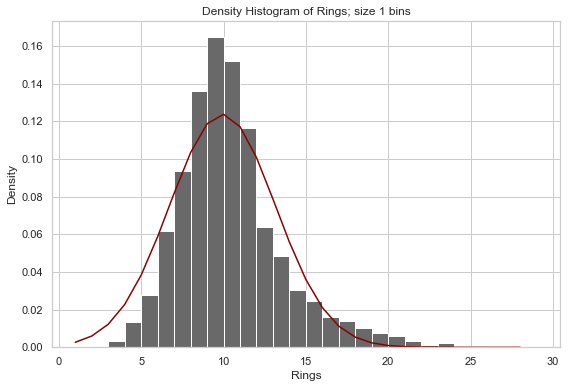

In [66]:
bins = [1 + i for i in range( 0, 29, 1)]

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "Rings"], bins=bins, color="DimGray", density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Rings")
axes.set_title("Density Histogram of Rings; size 1 bins")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
mean = np.mean(data["Rings"])
std = np.std(data["Rings"])
ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()


This shows more so how scrunched and tight the data is in the middle. The normal is ok but there is a higher concentration than what would be expeceted from the normal in the higher values and right around the mean.